In [1]:
##########################################################################
# Created on Sat Nov 20 21:49:45 2021                                    #
# Python for Financial Analysis and Risk Management                      #
# @author: Meng Lipeng (FRM, CFA)                                        #
##########################################################################

# 14.4.2.Caplet

**Mathimatical expression**

Return of interest rate cap at time $t_{i+1}$ is
$$L\tau_i max(R_i-R_K,0)\tag{14-28}$$
where,\
$L$:Notional amount\
$\tau_i$:$t_{i+1}-t_i$\
$R_i$:Floating rate observed at $t_i$\
$R_K$:Cap rate

According Black model,\
$$caplet=L\tau_i e^{-Rt_{i+1}}[F_iN(d_1)-R_KN(d_2)]\tag{14-29}$$
$$d_1=\frac{ln(F_i/R_K)+{\sigma_i}^2t_i/2}{\sigma_i \sqrt{t_i}}$$
$$d_2=\frac{ln(F_i/R_K)-{\sigma_i}^2t_i/2}{\sigma_i \sqrt{t_i}}=d_1-\sigma_i\sqrt{t_i}$$
where,\
$N(\cdot)$:CDF(Cumulative Distribution Function) of standard normal distribution

**Implementation**

In [2]:
def caplet(L,R,F,Rk,sigma,t1,t2):
    '''Define a function to calculate caplet value using Black model.
    L:notional amount
    R:risk free rate(continuous compound)
    F:Forward interest rate of ti to ti+1 observed at t0
    Rk:cap rate(strike price)
    sigma:volatility of forward interest rate
    t1:time t1 in year
    t2:time t2 in year'''
    from numpy import log, exp, sqrt
    from scipy.stats import norm
    
    d1=(log(F/Rk)+pow(sigma,2)*t1/2)/(sigma*sqrt(t1))
    d2=d1-sigma*sqrt(t1)
    tau=t2-t1
    value=L*tau*exp(-R*t2)*(F*norm.cdf(d1)-Rk*norm.cdf(d2))
    return value

**Case study**

In [3]:
import pandas as pd

shibor_list=pd.read_excel('Shibor(201901-20200320).xlsx',engine='openpyxl',sheet_name="Sheet1",header=0,index_col=0)
shibor_list.columns

Index(['SHIBOR(3M)', 'SHIBOR(6M)', 'SHIBOR(9M)', 'SHIBOR(12M)'], dtype='object')

In [4]:
def Rf(R1,R2,T1,T2):
    '''Define a function for calculating forward rate
    R1: Zero rate of tenor T1 (Continuous compound)
    R2: Zero rate of tenor T2 (Continuous compound)
    T1: Tenor1 (year)
    T2: Tenor2 (year)'''
    forward_rate=R2+(R2-R1)*T1/(T2-T1)
    return forward_rate

In [5]:
import numpy as np

FR1_list=Rf(R1=shibor_list['SHIBOR(3M)'],R2=shibor_list['SHIBOR(6M)'],T1=3/12,T2=6/12)
FR2_list=Rf(R1=shibor_list['SHIBOR(6M)'],R2=shibor_list['SHIBOR(9M)'],T1=6/12,T2=9/12)
FR3_list=Rf(R1=shibor_list['SHIBOR(9M)'],R2=shibor_list['SHIBOR(12M)'],T1=9/12,T2=12/12)

return_FR1=np.log(FR1_list/FR1_list.shift(1))
return_FR2=np.log(FR2_list/FR2_list.shift(1))
return_FR3=np.log(FR3_list/FR3_list.shift(1))

sigma_FR1=np.sqrt(252)*return_FR1.std()
sigma_FR2=np.sqrt(252)*return_FR2.std()
sigma_FR3=np.sqrt(252)*return_FR3.std()

print('Volatility of 3M forward interest rate after 3M is ',round(sigma_FR1,6))
print('Volatility of 3M forward interest rate after 9M is ',round(sigma_FR2,6))
print('Volatility of 3M forward interest rate after 12M is ',round(sigma_FR3,6))

Volatility of 3M forward interest rate after 3M is  0.064905
Volatility of 3M forward interest rate after 9M is  0.073253
Volatility of 3M forward interest rate after 12M is  0.081398


In [6]:
FR1_Mar20=FR1_list[-1]
FR2_Mar20=FR2_list[-1]
FR3_Mar20=FR3_list[-1]

R_6M=0.017049
R_9M=0.018499
R_12M=0.018682

par=1e8
cap_rate=0.022

caplet1=caplet(L=par,R=R_6M,F=FR1_Mar20,Rk=cap_rate,sigma=sigma_FR1,t1=3/12,t2=6/12)
caplet2=caplet(L=par,R=R_9M,F=FR2_Mar20,Rk=cap_rate,sigma=sigma_FR2,t1=6/12,t2=9/12)
caplet3=caplet(L=par,R=R_12M,F=FR3_Mar20,Rk=cap_rate,sigma=sigma_FR3,t1=9/12,t2=1)

print('Value of caplet(floating rate reset after 3M and payment at 6M) is ',round(caplet1,2))
print('Value of caplet(floating rate reset after 6M and payment at 9M) is ',round(caplet2,2))
print('Value of caplet(floating rate reset after 9M and payment at 12M) is ',round(caplet3,2))

Value of caplet(floating rate reset after 3M and payment at 6M) is  37081.21
Value of caplet(floating rate reset after 6M and payment at 9M) is  96163.37
Value of caplet(floating rate reset after 9M and payment at 12M) is  129080.1


In [7]:
cap=caplet1+caplet2+caplet3
print('Value of cap at initial date is ',round(cap,2))

Value of cap at initial date is  262324.68


# 14.4.3.Floorlet and collar

### 1.Floorlet pricing

Return of interest rate floor at time $t_{i+1}$ is
$$L\tau_i max(R_K-R_i,0)\tag{14-30}$$
where,\
$L$:Notional amount\
$\tau_i$:$t_{i+1}-t_i$\
$R_i$:Floating rate observed at $t_i$\
$R_K$:Floor rate

According Black model,\
$$floorlet=L\tau_i e^{-Rt_{i+1}}[R_KN(-d_2)-F_iN(-d_1)]\tag{14-31}$$
$$d_1=\frac{ln(F_i/R_K)+{\sigma_i}^2t_i/2}{\sigma_i \sqrt{t_i}}$$
$$d_2=\frac{ln(F_i/R_K)-{\sigma_i}^2t_i/2}{\sigma_i \sqrt{t_i}}=d_1-\sigma_i\sqrt{t_i}$$
where,\
$N(\cdot)$:CDF(Cumulative Distribution Function) of standard normal distribution

### 2.Implementation

In [8]:
def floorlet(L,R,F,Rk,sigma,t1,t2):
    '''Define a function to calculate floorlet value using Black model.
    L:notional amount
    R:risk free rate(continuous compound)
    F:Forward interest rate of ti to ti+1 observed at t0
    Rk:cap rate(strike price)
    sigma:volatility of forward interest rate
    t1:time t1 in year
    t2:time t2 in year'''
    from numpy import log, exp, sqrt
    from scipy.stats import norm
    
    d1=(log(F/Rk)+pow(sigma,2)*t1/2)/(sigma*sqrt(t1))
    d2=d1-sigma*sqrt(t1)
    tau=t2-t1
    value=L*tau*exp(-R*t2)*(Rk*norm.cdf(-d2)-F*norm.cdf(-d1))
    return value

### 3.Case study

In [9]:
floor_rate=0.025

floorlet1=floorlet(L=par,R=R_6M,F=FR1_Mar20,Rk=floor_rate,sigma=sigma_FR1,t1=3/12,t2=6/12)
floorlet2=floorlet(L=par,R=R_9M,F=FR2_Mar20,Rk=floor_rate,sigma=sigma_FR2,t1=6/12,t2=9/12)
floorlet3=floorlet(L=par,R=R_12M,F=FR3_Mar20,Rk=floor_rate,sigma=sigma_FR3,t1=9/12,t2=1)

print('Value of floorlet(floating rate reset after 3M and payment at 6M) is ',round(floorlet1,2))
print('Value of floorlet(floating rate reset after 6M and payment at 9M) is ',round(floorlet2,2))
print('Value of floorlet(floating rate reset after 9M and payment at 12M) is ',round(floorlet3,2))

Value of floorlet(floating rate reset after 3M and payment at 6M) is  37634.23
Value of floorlet(floating rate reset after 6M and payment at 9M) is  4779.06
Value of floorlet(floating rate reset after 9M and payment at 12M) is  2391.65


In [10]:
floor=floorlet1+floorlet2+floorlet3
print('Value of floor at initial date is ',round(floor,2))

Value of floor at initial date is  44804.94


### 4.Collar

Long collar=long cap + short floor\
Short collar=short cap + long floor

In [11]:
par_new=1e9
cap_rate_new=0.029
floor_rate_new=0.023

caplet1_new=caplet(L=par_new,R=R_6M,F=FR1_Mar20,Rk=cap_rate_new,sigma=sigma_FR1,t1=3/12,t2=6/12)
caplet2_new=caplet(L=par_new,R=R_9M,F=FR2_Mar20,Rk=cap_rate_new,sigma=sigma_FR2,t1=6/12,t2=9/12)
caplet3_new=caplet(L=par_new,R=R_12M,F=FR3_Mar20,Rk=cap_rate_new,sigma=sigma_FR3,t1=9/12,t2=1)

floorlet1_new=floorlet(L=par_new,R=R_6M,F=FR1_Mar20,Rk=floor_rate_new,sigma=sigma_FR1,t1=3/12,t2=6/12)
floorlet2_new=floorlet(L=par_new,R=R_9M,F=FR2_Mar20,Rk=floor_rate_new,sigma=sigma_FR2,t1=6/12,t2=9/12)
floorlet3_new=floorlet(L=par_new,R=R_12M,F=FR3_Mar20,Rk=floor_rate_new,sigma=sigma_FR3,t1=9/12,t2=1)

cap_new=caplet1_new+caplet2_new+caplet3_new
print('Value of cap at initial date is ',round(cap_new,2))
floor_new=floorlet1_new+floorlet2_new+floorlet3_new
print('Value of floor at initial date is ',round(floor_new,2))
collar_long=cap_new-floor_new
print('Value of collar is ',round(collar_long,2))

Value of cap at initial date is  52643.84
Value of floor at initial date is  31376.4
Value of collar is  21267.44


# 14.4.4.Swaption

### 2.Pricing swaption

**Pay fixed, receive floating swaption**

$$cashflow=\frac{L}{m}max(s_t-s_k,0)\tag{14-32}$$
where,\
$L$:Notional amount\
$m$:Payment frequency per year\
$s_t$:Swap rate when swaption expires\
$s_k$:Strike swap rate

According Black model,\
$$swaption=\sum_{i=1}^{mn} e^{-R_i T_i}\frac{L}{m}[s_fN(d_1)-s_kN(d_2)]\tag{14-33}$$
$$d_1=\frac{ln(s_f/s_k)+{\sigma}^2t/2}{\sigma \sqrt{t}}$$
$$d_2=\frac{ln(s_f/s_k)-{\sigma}^2t/2}{\sigma \sqrt{t}}=d_1-\sigma\sqrt{t}$$
where,\
n:Swap tenor in year\
t:Option tenor in year\
$T_i=t+i/m$\
$Ri$:Tenor $T_i$ risk free rate(continuous compound)\
$s_f$:Forward swap rate at option initial date\
$\sigma$:Volatility of forward swap rate

$$s_f=\frac{(1+s_0/m)^{-mt}-(1+s_{mn}/m)^{-m(t+n)}}{\sum_{i=1}^{mn}(T_i-T_{i-1})(1+s_i/m)^{-(mt+i)}}\tag{14-34}$$
where,\
$s_0$:Swap rate(tenor=t)observed at time 0\
$s_i$:Swap rate(tenor=$T_i$)oberved at time 0\
$s_{mn}$:Swap rate(tenor=$T_{mn}=t+n$)\
$T_0=t$

Since $T_i=t+i/m$, we can get $T_i-T_{i-1}=1/m$, (14-34) can be simplified as below
$$s_f=\frac{(1+s_0/m)^{-mt}-(1+s_{mn}/m)^{-m(t+n)}}{(1/m)\times\sum_{i=1}^{mn}(1+s_i/m)^{-(mt+i)}}\tag{14-35}$$

**Pay floating, receive fixed swaption**

$$cashflow=\frac{L}{m}max(s_k-s_t,0)\tag{14-36}$$

According Black model,\
$$swaption=\sum_{i=1}^{mn} e^{-R_i T_i}\frac{L}{m}[s_kN(-d_2)-s_fN(-d_1)]\tag{14-37}$$

### 3.Implementation

In [13]:
def swaption(L,Sf,Sk,m,sigma,t,n,R_list,direction):
    '''Define a function to calculate swaption value using Black model.
    L:notional amount
    Sf:forward swap rate
    Sk:strike swap rate
    m:payment frequency per year(compound frequency)
    sigma:volatility of forward swap rate
    t:option tenor in year
    n:swap tenor in year
    R_list:Tenor $T_i$ risk free rate(continuous compound)
    direction:'pay'indicated fixed payer, otherwise fixed receiver'''
    from numpy import arange,log, exp, sqrt
    from scipy.stats import norm
    
    d1=(log(Sf/Sk)+pow(sigma,2)*t/2)/(sigma*sqrt(t))
    d2=d1-sigma*sqrt(t)
    T_list=t+arange(1,m*n+1)/m
    if direction=='pay':
        value=np.sum(exp(-R_list*T_list)*L*(Sf*norm.cdf(d1)-Sk*norm.cdf(d2))/m)
    else:
        value=np.sum(exp(-R_list*T_list)*L*(Sk*norm.cdf(-d2)-Sf*norm.cdf(-d1))/m)
    
    return value

In [18]:
def forward_swaprate(S_list,t,n,m):
    '''Define a function to calculate forward swap rate.
    S_list:different tenor swap rate observed at option initial date
    t:tenor of option
    n:tenor of swap
    m:payment frequency per year(compound frequency)'''
    t_list=m*t+np.arange(1,m*n+1)
    A=pow(1+S_list[0]/m,-m*t)-pow(1+S_list[-1]/m,-m*(t+n))
    B=(1/m)*np.sum(pow(1+S_list[1:]/m,-t_list))
    value=A/B
    return value

### 4.Case study

In [15]:
swaprate_list=pd.read_excel('Shibor swap rate(201901-20200901).xlsx',engine='openpyxl',sheet_name="Sheet1",header=0,index_col=0)
swaprate_list.columns

Index(['Shibor Swap rate(6M)', 'Shibor Swap rate(9M)', 'Shibor Swap rate(1Y)'], dtype='object')

In [16]:
swaprate_list.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-24',
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-31', '2020-09-01'],
              dtype='datetime64[ns]', name='Date', length=416, freq=None)

Text(0, 0.5, 'Interest rate')

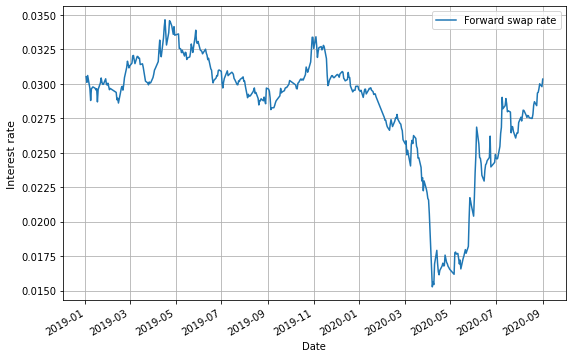

In [22]:
import matplotlib.pyplot as plt
T_swaption=0.5
T_swap=0.5
M=4

forward_list=np.zeros(len(swaprate_list.index))
for i in range(len(swaprate_list.index)):
    forward_list[i]=forward_swaprate(S_list=swaprate_list.iloc[i],t=T_swaption,n=T_swap,m=M)
forward_list=pd.DataFrame(data=forward_list,index=swaprate_list.index,columns=['Forward swap rate'])
forward_list.plot(figsize=(9,6),grid=True)
plt.ylabel('Interest rate',fontsize=11)

In [23]:
return_forward=np.log(forward_list/forward_list.shift(1))
sigma_forward=np.sqrt(252)*return_forward.std()
sigma_forward=float(sigma_forward)
print('Annualized volatility of forward swap rate is ',round(sigma_forward,6))

Annualized volatility of forward swap rate is  0.40548


In [24]:
forward_Sep1=float(forward_list.iloc[-1])
print('Foward swap rate at option initial date is ',round(forward_Sep1,6))

Foward swap rate at option initial date is  0.03035


In [26]:
par=1e8
rate_fixed=0.029

R_norisk=np.array(swaprate_list.iloc[-1]) #Quarterly compound

def Rc(Rm,m):
    '''Define a function that when Rm and m frequency are known, calculate continuous IR
    Rm: IR of m frequency
    m: Compound frequency'''
    r=m*np.log(1+Rm/m)
    return r

Rc_norisk=Rc(Rm=R_norisk,m=M)
Rc_9M_12M=Rc_norisk[1:]

value=swaption(L=par,Sf=forward_Sep1,Sk=rate_fixed,m=M,sigma=sigma_forward,t=T_swaption,n=T_swap,R_list=Rc_9M_12M,direction='receive')
print('Value of swaption at initial date is ',round(value,2))

Value of swaption at initial date is  133988.26
